In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim

# Set domain limits
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0
z_min, z_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0
nu = 0.01  # Viscosity

# Neural Network model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)  # Output: (u, v, w)
        )

    def forward(self, x):
        return self.net(x)

# PDE residual
def burgers_pde_residual(model, xyt):
    xyt.requires_grad_(True)
    pred = model(xyt)
    u, v, w = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]

    grads = autograd.grad(pred, xyt, grad_outputs=torch.ones_like(pred), create_graph=True)[0]
    u_x, u_y, u_z, u_t = grads[:, 0:1], grads[:, 1:2], grads[:, 2:3], grads[:, 3:4]

    grads2 = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = autograd.grad(u_x, xyt, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = autograd.grad(u_y, xyt, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    u_zz = autograd.grad(u_z, xyt, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:, 2:3]

    grads2 = autograd.grad(v, xyt, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x, v_y, v_z, v_t = grads2[:, 0:1], grads2[:, 1:2], grads2[:, 2:3], grads2[:, 3:4]
    v_xx = autograd.grad(v_x, xyt, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0:1]
    v_yy = autograd.grad(v_y, xyt, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1:2]
    v_zz = autograd.grad(v_z, xyt, grad_outputs=torch.ones_like(v_z), create_graph=True)[0][:, 2:3]

    grads2 = autograd.grad(w, xyt, grad_outputs=torch.ones_like(w), create_graph=True)[0]
    w_x, w_y, w_z, w_t = grads2[:, 0:1], grads2[:, 1:2], grads2[:, 2:3], grads2[:, 3:4]
    w_xx = autograd.grad(w_x, xyt, grad_outputs=torch.ones_like(w_x), create_graph=True)[0][:, 0:1]
    w_yy = autograd.grad(w_y, xyt, grad_outputs=torch.ones_like(w_y), create_graph=True)[0][:, 1:2]
    w_zz = autograd.grad(w_z, xyt, grad_outputs=torch.ones_like(w_z), create_graph=True)[0][:, 2:3]

    res_u = u_t + u * u_x + v * u_y + w * u_z - nu * (u_xx + u_yy + u_zz)
    res_v = v_t + u * v_x + v * v_y + w * v_z - nu * (v_xx + v_yy + v_zz)
    res_w = w_t + u * w_x + v * w_y + w * w_z - nu * (w_xx + w_yy + w_zz)

    return res_u, res_v, res_w

# Initial condition
def generate_initial_data(n):
    x = torch.rand(n, 1) * (x_max - x_min)
    y = torch.rand(n, 1) * (y_max - y_min)
    z = torch.rand(n, 1) * (z_max - z_min)
    t = torch.zeros_like(x)
    u0 = torch.zeros_like(x)  # example IC: zero velocity
    v0 = torch.zeros_like(y)
    w0 = torch.zeros_like(z)
    X = torch.cat([x, y, z, t], dim=1)
    U = torch.cat([u0, v0, w0], dim=1)
    return X, U

# Boundary condition
def generate_boundary_data(n):
    t = torch.rand(n, 1) * (t_max - t_min)
    boundary_points = []

    for i in range(3):  # x, y, z boundaries
        for bound in [0.0, 1.0]:
            xyz = torch.rand(n, 3)
            xyz[:, i] = bound
            X = torch.cat([xyz, t], dim=1)
            U = torch.zeros(n, 3)  # Dirichlet BC: zero velocity
            boundary_points.append((X, U))

    X_bc = torch.cat([item[0] for item in boundary_points], dim=0)
    U_bc = torch.cat([item[1] for item in boundary_points], dim=0)
    return X_bc, U_bc

# PDE collocation points
def generate_collocation_points(n):
    x = torch.rand(n, 1) * (x_max - x_min)
    y = torch.rand(n, 1) * (y_max - y_min)
    z = torch.rand(n, 1) * (z_max - z_min)
    t = torch.rand(n, 1) * (t_max - t_min)
    return torch.cat([x, y, z, t], dim=1)

# Initialize
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training data
X_ic, U_ic = generate_initial_data(1000)
X_bc, U_bc = generate_boundary_data(1000)
X_pde = generate_collocation_points(5000)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()

    # PDE residual loss
    res_u, res_v, res_w = burgers_pde_residual(model, X_pde)
    loss_pde = torch.mean(res_u**2 + res_v**2 + res_w**2)

    # Initial condition loss
    pred_ic = model(X_ic)
    loss_ic = torch.mean((pred_ic - U_ic)**2)

    # Boundary condition loss
    pred_bc = model(X_bc)
    loss_bc = torch.mean((pred_bc - U_bc)**2)

    # Total loss
    loss = loss_pde + loss_ic + loss_bc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}")

print("Training Complete!")


Epoch 0, Total Loss: 0.044638
Epoch 500, Total Loss: 0.000008
Epoch 1000, Total Loss: 0.000005
Epoch 1500, Total Loss: 0.000002
Epoch 2000, Total Loss: 0.000002
Epoch 2500, Total Loss: 0.000001
Epoch 3000, Total Loss: 0.000014
Epoch 3500, Total Loss: 0.000002
Epoch 4000, Total Loss: 0.000000
Epoch 4500, Total Loss: 0.000000
Epoch 5000, Total Loss: 0.000000
Epoch 5500, Total Loss: 0.000000
Epoch 6000, Total Loss: 0.000000
Epoch 6500, Total Loss: 0.000047
Epoch 7000, Total Loss: 0.000000
Epoch 7500, Total Loss: 0.000000
Epoch 8000, Total Loss: 0.000034
Epoch 8500, Total Loss: 0.000000
Epoch 9000, Total Loss: 0.000000
Epoch 9500, Total Loss: 0.000000
Training Complete!


Epoch 0, Total Loss: 0.059362
Epoch 500, Total Loss: 0.000006
Epoch 1000, Total Loss: 0.000002
Epoch 1500, Total Loss: 0.000001
Epoch 2000, Total Loss: 0.000010
Epoch 2500, Total Loss: 0.000014
Epoch 3000, Total Loss: 0.000000
Epoch 3500, Total Loss: 0.000001
Epoch 4000, Total Loss: 0.000000
Epoch 4500, Total Loss: 0.000000
Epoch 5000, Total Loss: 0.000000
Epoch 5500, Total Loss: 0.000002
Epoch 6000, Total Loss: 0.000006
Epoch 6500, Total Loss: 0.000000
Epoch 7000, Total Loss: 0.000000
Epoch 7500, Total Loss: 0.000004
Epoch 8000, Total Loss: 0.000000
Epoch 8500, Total Loss: 0.000001
Epoch 9000, Total Loss: 0.000000
Epoch 9500, Total Loss: 0.000000
Training Complete!


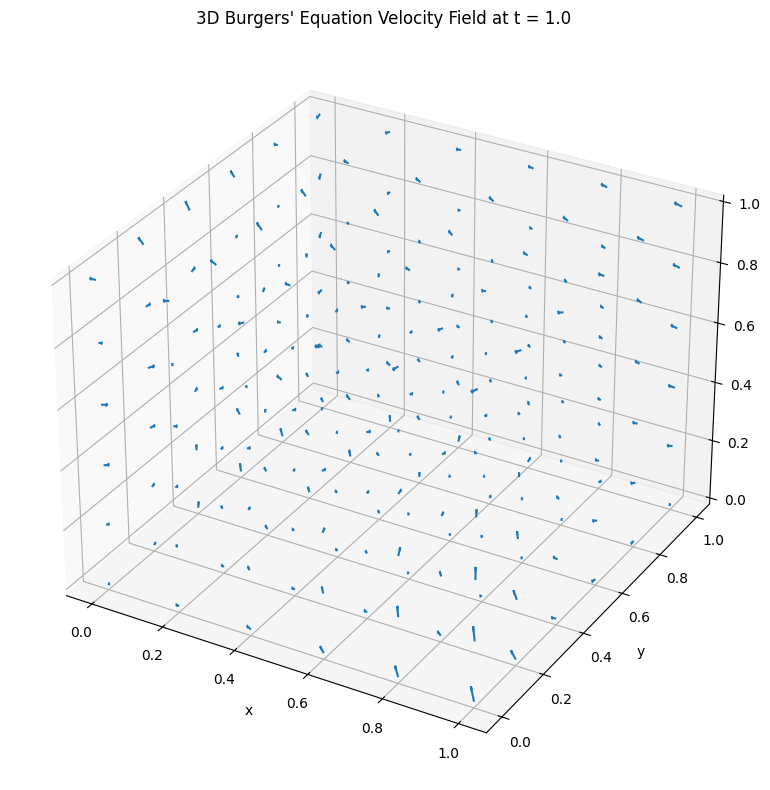

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set domain limits
x_min, x_max = 0.0, 1.0
y_min, y_max = 0.0, 1.0
z_min, z_max = 0.0, 1.0
t_min, t_max = 0.0, 1.0
nu = 0.01  # Viscosity

# Neural Network model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3)  # Output: (u, v, w)
        )

    def forward(self, x):
        return self.net(x)

# PDE residual
def burgers_pde_residual(model, xyt):
    xyt.requires_grad_(True)
    pred = model(xyt)
    u, v, w = pred[:, 0:1], pred[:, 1:2], pred[:, 2:3]

    grads = autograd.grad(pred, xyt, grad_outputs=torch.ones_like(pred), create_graph=True)[0]
    u_x, u_y, u_z, u_t = grads[:, 0:1], grads[:, 1:2], grads[:, 2:3], grads[:, 3:4]

    grads2 = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = autograd.grad(u_x, xyt, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = autograd.grad(u_y, xyt, grad_outputs=torch.ones_like(u_y), create_graph=True)[0][:, 1:2]
    u_zz = autograd.grad(u_z, xyt, grad_outputs=torch.ones_like(u_z), create_graph=True)[0][:, 2:3]

    grads2 = autograd.grad(v, xyt, grad_outputs=torch.ones_like(v), create_graph=True)[0]
    v_x, v_y, v_z, v_t = grads2[:, 0:1], grads2[:, 1:2], grads2[:, 2:3], grads2[:, 3:4]
    v_xx = autograd.grad(v_x, xyt, grad_outputs=torch.ones_like(v_x), create_graph=True)[0][:, 0:1]
    v_yy = autograd.grad(v_y, xyt, grad_outputs=torch.ones_like(v_y), create_graph=True)[0][:, 1:2]
    v_zz = autograd.grad(v_z, xyt, grad_outputs=torch.ones_like(v_z), create_graph=True)[0][:, 2:3]

    grads2 = autograd.grad(w, xyt, grad_outputs=torch.ones_like(w), create_graph=True)[0]
    w_x, w_y, w_z, w_t = grads2[:, 0:1], grads2[:, 1:2], grads2[:, 2:3], grads2[:, 3:4]
    w_xx = autograd.grad(w_x, xyt, grad_outputs=torch.ones_like(w_x), create_graph=True)[0][:, 0:1]
    w_yy = autograd.grad(w_y, xyt, grad_outputs=torch.ones_like(w_y), create_graph=True)[0][:, 1:2]
    w_zz = autograd.grad(w_z, xyt, grad_outputs=torch.ones_like(w_z), create_graph=True)[0][:, 2:3]

    res_u = u_t + u * u_x + v * u_y + w * u_z - nu * (u_xx + u_yy + u_zz)
    res_v = v_t + u * v_x + v * v_y + w * v_z - nu * (v_xx + v_yy + v_zz)
    res_w = w_t + u * w_x + v * w_y + w * w_z - nu * (w_xx + w_yy + w_zz)

    return res_u, res_v, res_w

# Initial condition
def generate_initial_data(n):
    x = torch.rand(n, 1) * (x_max - x_min)
    y = torch.rand(n, 1) * (y_max - y_min)
    z = torch.rand(n, 1) * (z_max - z_min)
    t = torch.zeros_like(x)
    u0 = torch.zeros_like(x)
    v0 = torch.zeros_like(y)
    w0 = torch.zeros_like(z)
    X = torch.cat([x, y, z, t], dim=1)
    U = torch.cat([u0, v0, w0], dim=1)
    return X, U

# Boundary condition
def generate_boundary_data(n):
    t = torch.rand(n, 1) * (t_max - t_min)
    boundary_points = []
    for i in range(3):
        for bound in [0.0, 1.0]:
            xyz = torch.rand(n, 3)
            xyz[:, i] = bound
            X = torch.cat([xyz, t], dim=1)
            U = torch.zeros(n, 3)
            boundary_points.append((X, U))
    X_bc = torch.cat([item[0] for item in boundary_points], dim=0)
    U_bc = torch.cat([item[1] for item in boundary_points], dim=0)
    return X_bc, U_bc

def generate_collocation_points(n):
    x = torch.rand(n, 1) * (x_max - x_min)
    y = torch.rand(n, 1) * (y_max - y_min)
    z = torch.rand(n, 1) * (z_max - z_min)
    t = torch.rand(n, 1) * (t_max - t_min)
    return torch.cat([x, y, z, t], dim=1)

# Initialize and train model
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
X_ic, U_ic = generate_initial_data(1000)
X_bc, U_bc = generate_boundary_data(1000)
X_pde = generate_collocation_points(5000)

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    res_u, res_v, res_w = burgers_pde_residual(model, X_pde)
    loss_pde = torch.mean(res_u**2 + res_v**2 + res_w**2)
    pred_ic = model(X_ic)
    loss_ic = torch.mean((pred_ic - U_ic)**2)
    pred_bc = model(X_bc)
    loss_bc = torch.mean((pred_bc - U_bc)**2)
    loss = loss_pde + loss_ic + loss_bc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}")

print("Training Complete!")

# --- Solution Visualization ---
model.eval()
grid_points = 6
x = np.linspace(0, 1, grid_points)
y = np.linspace(0, 1, grid_points)
z = np.linspace(0, 1, grid_points)
t_val = 1.0
X, Y, Z = np.meshgrid(x, y, z)
X_flat = X.flatten()
Y_flat = Y.flatten()
Z_flat = Z.flatten()
T_flat = np.full_like(X_flat, t_val)
grid_input = np.stack([X_flat, Y_flat, Z_flat, T_flat], axis=1)
grid_tensor = torch.tensor(grid_input, dtype=torch.float32)

with torch.no_grad():
    pred = model(grid_tensor).numpy()
U = pred[:, 0]
V = pred[:, 1]
W = pred[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X_flat, Y_flat, Z_flat, U, V, W, length=0.05, normalize=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("3D Burgers' Equation Velocity Field at t = 1.0")
plt.tight_layout()
plt.show()
